In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import dill

import sys
sys.path.append("../../")

import biked_commons
from biked_commons.prediction import aero_predictor, loaders
from biked_commons.resource_utils import models_and_scalers_path
from biked_commons.prediction.prediction_utils import TorchStandardScaler, DNN, Preprocessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
X_tv, Y_tv = loaders.load_aero()
X_tv_tens = torch.tensor(X_tv.values, dtype=torch.float32, device=device)
Y_tv_tens = torch.tensor(Y_tv.values, dtype=torch.float32, device=device)

In [3]:
X_tv_tens = aero_predictor.calculate_features(X_tv_tens, device=device)

In [4]:
scaler = TorchStandardScaler().to(device)
scaler.fit(X_tv_tens)


scaler_path = models_and_scalers_path("aero_scaler.pt")
torch.save(scaler, scaler_path)

X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)

C:\Users\Lyle\AppData\Local\Temp\ipykernel_40728\4180995027.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)


In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tv_tens, Y_tv_tens, test_size=0.2, random_state=42)

In [11]:
# Define the model, loss function, and optimizer
input_dim = X_train.shape[1]
output_dim = 1
model = DNN(input_dim, layer_sizes=(128, 128)).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
batch_size = 32
best_val_loss = float('inf')
best_model = None

bar = trange(num_epochs, desc="Training")
for epoch in bar:
    model.train()
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model = model

    bar.set_postfix({
        'loss': f'{loss.item():.4f}',
        'val_loss': f'{val_loss.item():.4f}',
        'best_val': f'{best_val_loss:.4f}'
    })



Training: 100%|██████████| 500/500 [00:54<00:00,  9.24it/s, loss=0.8630, val_loss=0.2640, best_val=0.2452] 


In [12]:
save_path = models_and_scalers_path("aero_model.pt")
torch.save(best_model, save_path)

In [13]:
model = torch.load(save_path)

Text(0.5, 1.0, 'R2 Score: 0.9624')

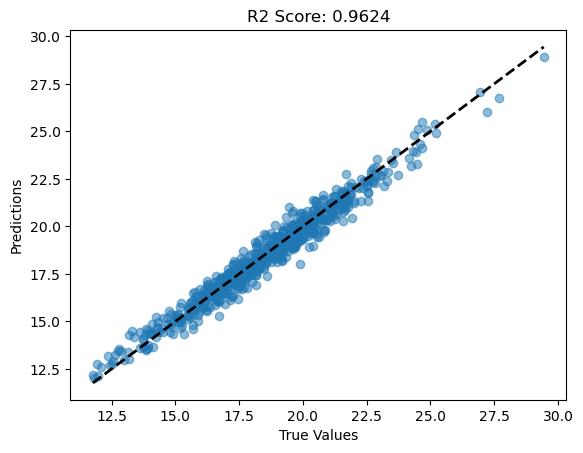

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Calculate metrics

Y_val_npy = Y_val.cpu().detach().numpy()
val_outputs = best_model(X_val).cpu().detach().numpy()
r2 = r2_score(Y_val_npy, val_outputs)

plt.scatter(Y_val_npy, val_outputs, alpha=0.5)
plt.plot([Y_val_npy.min(), Y_val_npy.max()], [Y_val_npy.min(), Y_val_npy.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'R2 Score: {r2:.4f}')

In [15]:
import evaluators

evaluators.evaluate_aero(model, Preprocessor(scaler_path=scaler_path, preprocess_fn=aero_predictor.calculate_features, device=device), device=device)

0.9575423520113032